In [38]:
%pip install pandas numpy matplotlib scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [39]:
import os
from glob import glob

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
    
from IPython.display import Markdown, display

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import sys
sys.path.append('.')
from roco2_python import color, marker, plot, Kernel

In [40]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (20,10)
pylab.rcParams['font.size'] = 20
pylab.rcParams['legend.fontsize'] = 20
def printmd(string):
    display(Markdown(string))

In [41]:
filename = './results/results-60s.csv'

experiments = pd.read_csv(filename, sep=',')
experiments

,experiment,frequency,shell,threads,utility,op1,op2,sysfs-powercap-rapl,perf-ipc,perf-freq,ipc-estimate,metricq
0,2,0,0,224,1,0,0,271.323713,NaN,0.000001,0.0,959.787234
1,4,0,0,8,486582238,0,0,277.240573,2.120943,0.788375,0.0,962.000000
2,5,0,0,8,118830,0,0,277.327719,3.846415,0.788601,0.0,963.920000
3,8,0,0,8,713,0,0,281.567911,2.943184,0.786306,0.0,966.920000
4,14,0,0,8,487,0,0,282.541014,3.695946,0.786680,0.0,968.020000
...,...,...,...,...,...,...,...,...,...,...,...,...
2266,13,0,2,112,1,0,0,800.477878,1.867763,2.898452,0.0,1585.760000
2267,3,0,2,112,1,0,0,659.929087,2.121748,2.988263,0.0,1422.540000
2268,9,0,2,112,1,0,0,656.860960,2.117899,2.988329,0.0,1419.760000
2269,11,0,2,112,1,0,0,575.921154,0.064478,2.988489,0.0,1320.600000


In [42]:
power_patterns = {
    'metricq': 'reference measurement [W]',
    'sysfs-powercap-rapl': 'RAPL psys or package + DRAM [W]',
    'perf-freq': 'Average CPU frequency [GHz]',
    'threads': 'Number of threads'
}

pattern_x = 'sysfs-powercap-rapl'
pattern_y = 'metricq'

experiments[pattern_x] = list(map(float, experiments[pattern_x]))
experiments[pattern_y] = list(map(float, experiments[pattern_y]))

experiment_basename = os.path.splitext(os.path.basename(filename))[0]
printmd("### Number of experiments in {}: {}".format(experiment_basename, len(experiments)))
    
label_x = power_patterns[pattern_x]
label_y = power_patterns[pattern_y]
power_x_columns = experiments.filter(regex=pattern_x)
power_y_columns = experiments.filter(regex=pattern_y)
printmd("### Using X-{} power metrics: {} [{}]" \
        .format(label_x, pattern_x, ', '.join(power_x_columns.columns.values)))
printmd("### Using Y-{} power metrics: {} [{}]" \
        .format(label_y, pattern_y, ', '.join(power_y_columns.columns.values)))

experiments['kernel'] = experiments.experiment.apply(Kernel)
    
experiments['power_x'] = power_x_columns.sum(1)
experiments['power_y'] = power_y_columns.sum(1)
experiments['frequency_mhz'] = (experiments['frequency'] / 1e6).astype(int)

printmd('### Kernels:')
printmd('\n'.join([' * {}'.format(x) for x in experiments.kernel.unique()]))

printmd('### Frequencies:')
printmd('\n'.join([' * {}'.format(x) for x in experiments.frequency_mhz.unique()]))

printmd('### Thread counts:')
printmd('\n'.join([' * {}'.format(x) for x in experiments.threads.unique()]))

### Number of experiments in results-60s: 2271

### Using X-RAPL psys or package + DRAM [W] power metrics: sysfs-powercap-rapl [sysfs-powercap-rapl]

### Using Y-reference measurement [W] power metrics: metricq [metricq]

### Kernels:

 * idle
 * busywait
 * compute
 * memory_read
 * memory_copy
 * memory_write
 * addpd
 * mulpd
 * sqrt
 * firestarter

### Frequencies:

 * 0

### Thread counts:

 * 224
 * 8
 * 16
 * 24
 * 32
 * 40
 * 48
 * 56
 * 64
 * 72
 * 80
 * 88
 * 96
 * 104
 * 112

PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/rapl-validation.pdf'.


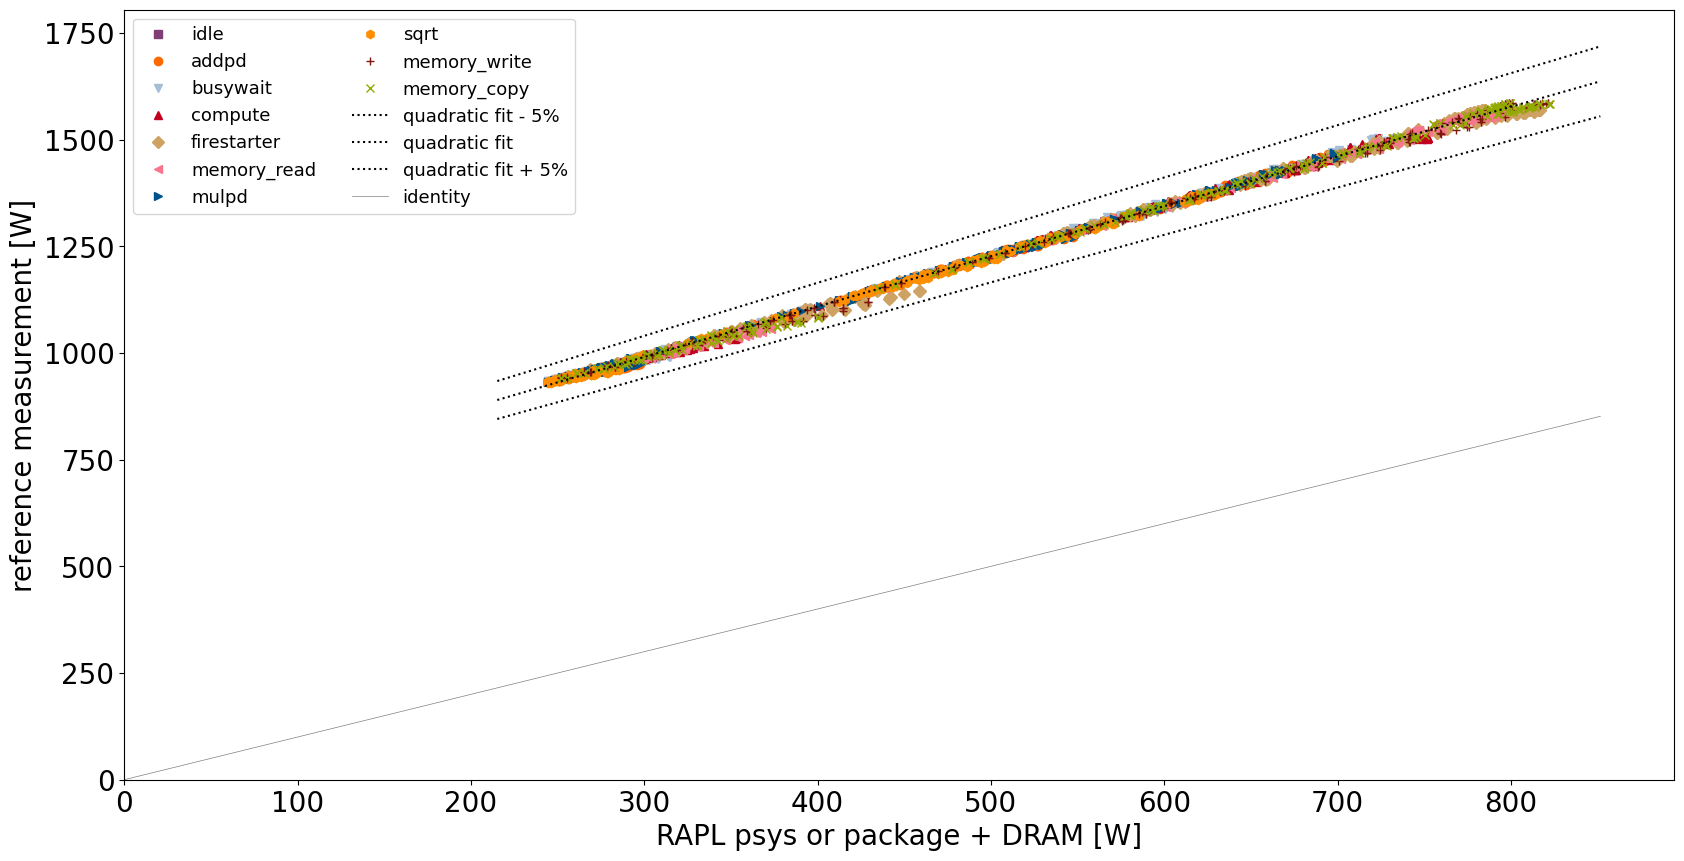

In [43]:
degree = 2

model = make_pipeline(PolynomialFeatures(degree), Ridge())
xses = experiments.power_x.to_numpy().reshape(-1, 1)
yses = experiments.power_y.to_numpy().reshape(-1, 1)
fit = model.fit(xses, yses)
names = {
    1: 'linear',
    2: 'quadratic',
    3: 'cubic'
}
model_name = names[degree]
params = mpl.rc_params()
params['font.size'] = 13
params['legend.fontsize'] = params['font.size']
params['figure.figsize'] = (10,6)

# with mpl.rc_context(params):
for kernel, k_group in experiments.groupby('kernel'):
    plt.plot(k_group.power_x, k_group.power_y, color=kernel.color, marker=kernel.marker, ls='', label=kernel.name)
x_min, x_max = plt.gca().get_xlim()
x_plot = np.linspace(x_min, x_max, 1000)
fit_y_vals = model.predict(x_plot.reshape(-1,1))
offset_in_percent = 5
fit_y_vals_minus_percent = list(map(lambda x: (1 - offset_in_percent / 100) * x, model.predict(x_plot.reshape(-1,1))))
fit_y_vals_plus_percent = list(map(lambda x: (1 + offset_in_percent / 100) * x, model.predict(x_plot.reshape(-1,1))))
plt.plot(x_plot, fit_y_vals_minus_percent, ls=':', color='black', label='{} fit - {}%'.format(model_name, offset_in_percent))
plt.plot(x_plot, fit_y_vals, ls=':', color='black', label='{} fit'.format(model_name))
plt.plot(x_plot, fit_y_vals_plus_percent, ls=':', color='black', label='{} fit + {}%'.format(model_name, offset_in_percent))
plt.xlabel(label_x)
plt.ylabel(label_y)
plot.ideal(x_max, ls='-', color='gray', label='identity')

plt.gca().set_xlim(xmin=0)
plt.gca().set_ylim(ymin=0)
plt.legend(loc='best', numpoints=1, fontsize=params['font.size'], ncol=2)
plot.make_pdf('../../thesis/fig/rapl-validation')

plt.show()
    
# fit(degree=2)